In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from google.colab import files
uploaded = files.upload()

df = pd.read_excel(r"Sales-profit project.xlsx")

Saving Sales-profit project.xlsx to Sales-profit project (1).xlsx


In [7]:
#What will our total Sales be for the next 3 months

In [8]:
import os
os.listdir()

['.config',
 'Sales-profit project (1).xlsx',
 'Sales-profit project.xlsx',
 'sample_data']

In [9]:
print(df.columns)


Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')


In [10]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df = df.sort_values('Order Date')


In [11]:
df['YearMonth'] = df['Order Date'].dt.to_period('M')
monthly_sales = df.groupby('YearMonth')['Sales'].sum().to_timestamp()


In [12]:
avg_last_3 = monthly_sales[-3:].mean()
future_months = pd.date_range(start=monthly_sales.index[-1] + pd.offsets.MonthBegin(), periods=3, freq='MS')
forecast = pd.Series([avg_last_3]*3, index=future_months)

print("Forecasted Sales for the Next 3 Months:")
print(forecast)


Forecasted Sales for the Next 3 Months:
2018-01-01    70592.199333
2018-02-01    70592.199333
2018-03-01    70592.199333
Freq: MS, dtype: float64


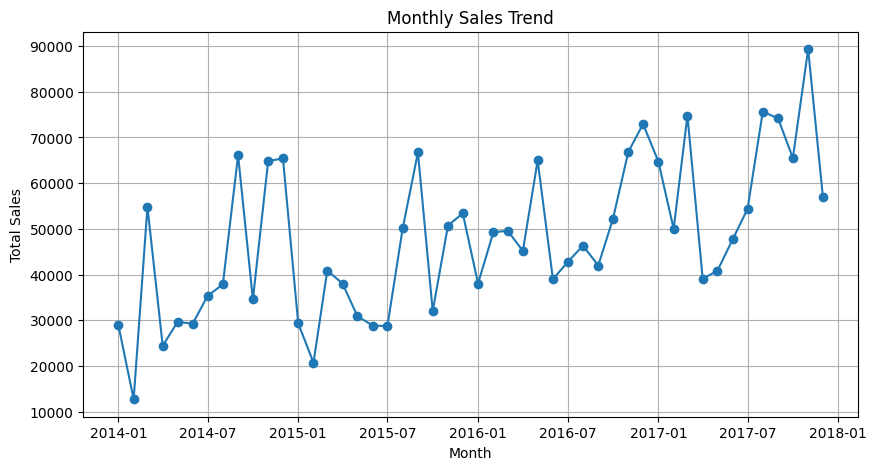

In [13]:
plt.figure(figsize=(10,5))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()


In [14]:
#Which Category (Furniture, Office Supplies, Technology) is likely to have the highest Sales in the next

In [16]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['YearMonth'] = df['Order Date'].dt.to_period('M')


In [17]:
category_monthly = df.groupby(['YearMonth', 'Category'])['Sales'].sum().unstack().to_timestamp()


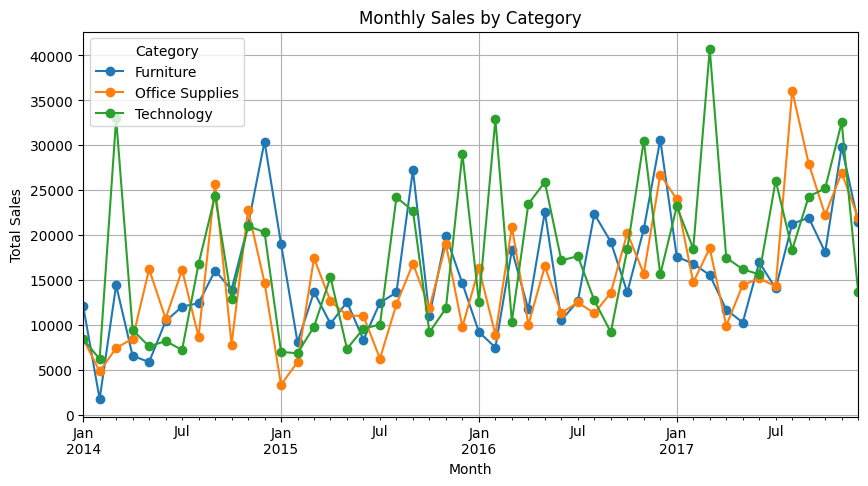

In [18]:
category_monthly.plot(figsize=(10,5), marker='o')
plt.title("Monthly Sales by Category")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()


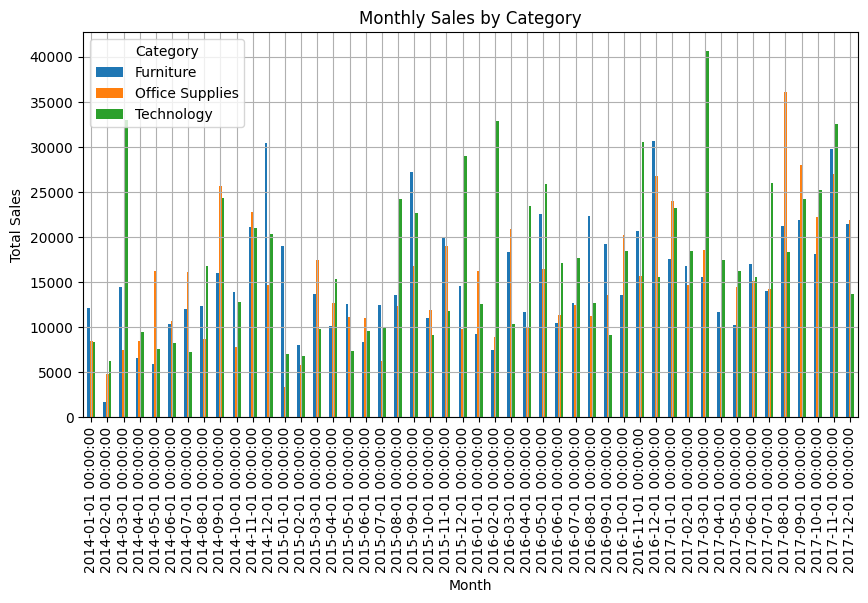

In [19]:
category_monthly.plot(kind='bar', figsize=(10,5))
plt.title("Monthly Sales by Category")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()


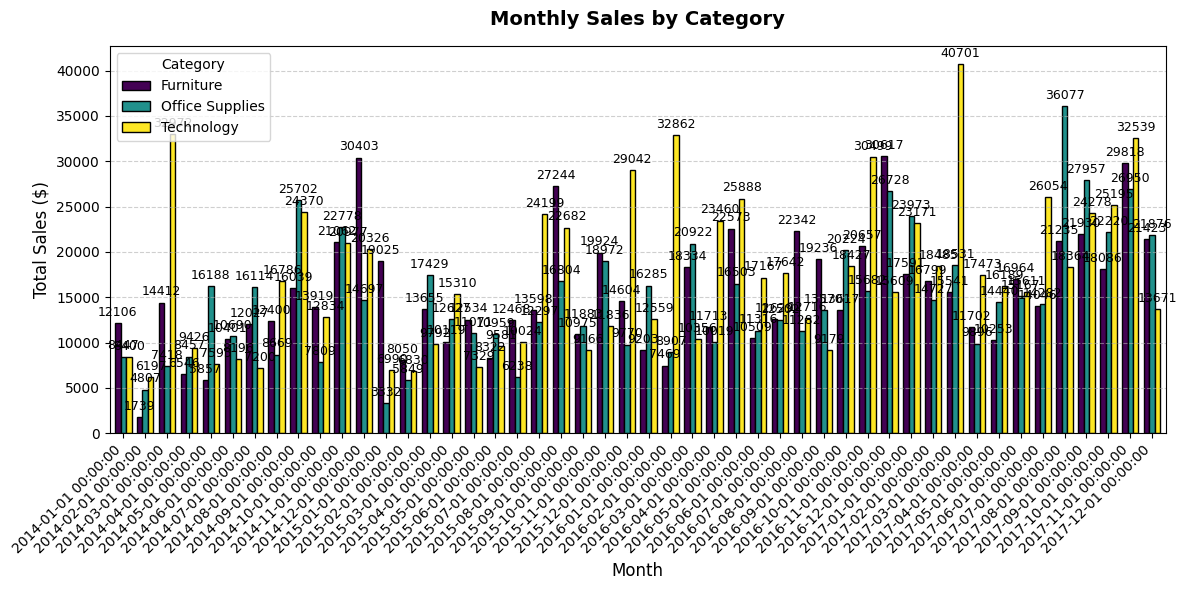

In [20]:

ax = category_monthly.plot(
    kind='bar',
    figsize=(12,6),
    width=0.75,
    colormap='viridis',
    edgecolor='black'
)


plt.title("Monthly Sales by Category", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Sales ($)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=9, padding=3)

plt.tight_layout()
plt.show()


In [21]:
forecast_next = category_monthly[-3:].mean()


In [22]:
print("Forecasted Average Monthly Sales for Each Category (Next Quarter):")
print(forecast_next)


Forecasted Average Monthly Sales for Each Category (Next Quarter):
Category
Furniture          23108.973333
Office Supplies    23681.806000
Technology         23801.420000
dtype: float64


In [23]:
top_category = forecast_next.idxmax()
print("The Category expected to have the highest Sales next quarter is:", top_category)


The Category expected to have the highest Sales next quarter is: Technology


In [24]:
#Based on past trends, what is our expected total Profit for the next month?


In [25]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df = df.sort_values('Order Date')


In [26]:
df['YearMonth'] = df['Order Date'].dt.to_period('M')


In [27]:
monthly_profit = df.groupby('YearMonth')['Profit'].sum().to_timestamp()


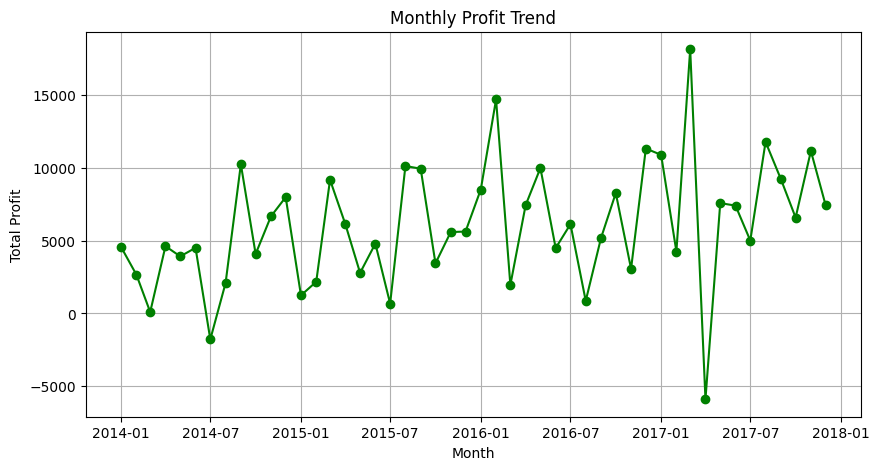

In [28]:
plt.figure(figsize=(10,5))
plt.plot(monthly_profit.index, monthly_profit.values, marker='o', color='green')
plt.title("Monthly Profit Trend")
plt.xlabel("Month")
plt.ylabel("Total Profit")
plt.grid(True)
plt.show()


In [29]:
avg_profit_last_3 = monthly_profit[-3:].mean()


In [30]:
next_month = monthly_profit.index[-1] + pd.offsets.MonthBegin()


In [31]:
print("Expected Profit for Next Month:")
print(f"{next_month.strftime('%Y-%m')}  →  ${avg_profit_last_3:,.2f}")


Expected Profit for Next Month:
2018-01  →  $8,375.86


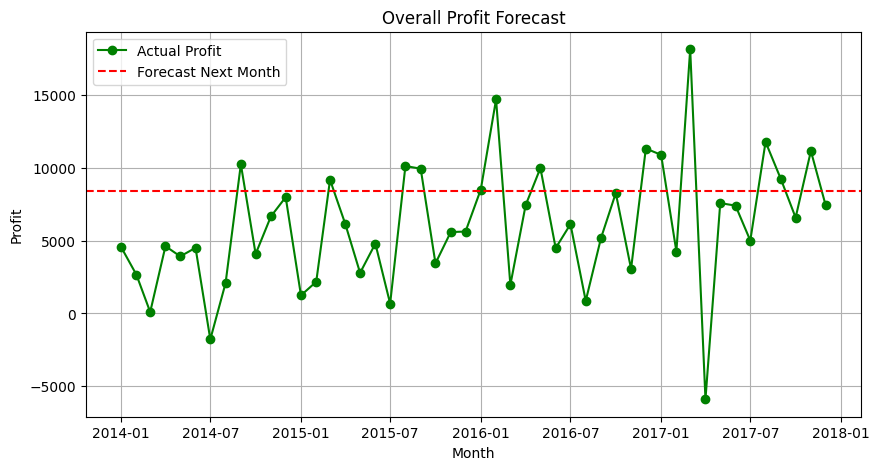

In [32]:
plt.figure(figsize=(10,5))
plt.plot(monthly_profit.index, monthly_profit.values, label="Actual Profit", marker='o', color='green')
plt.axhline(avg_profit_last_3, color='red', linestyle='--', label='Forecast Next Month')
plt.title("Overall Profit Forecast")
plt.xlabel("Month")
plt.ylabel("Profit")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
from sklearn.linear_model import LinearRegression

df['Order Date'] = pd.to_datetime(df['Order Date'])

def logical_forecast(data, target_col='Sales', months_to_predict=3, filter_col=None, filter_val=None):

    if filter_col and filter_val:
        data = data[data[filter_col] == filter_val]



    monthly_data = data.set_index('Order Date').resample('MS')[target_col].sum().reset_index()

    monthly_data['Time_Index'] = np.arange(len(monthly_data))

    monthly_data['Month'] = monthly_data['Order Date'].dt.month


    for m in range(2, 13):
        monthly_data[f'M_{m}'] = (monthly_data['Month'] == m).astype(int)


    feature_cols = ['Time_Index'] + [f'M_{m}' for m in range(2, 13)]


    if len(monthly_data) < 12:
        print(f"{filter_val if filter_val else 'All'}")

    X = monthly_data[feature_cols]
    y = monthly_data[target_col]


    model = LinearRegression()
    model.fit(X, y)


    last_idx = monthly_data['Time_Index'].max()
    last_date = monthly_data['Order Date'].max()

    future_dates = [last_date + pd.DateOffset(months=i) for i in range(1, months_to_predict + 1)]
    future_indices = [last_idx + i for i in range(1, months_to_predict + 1)]

    future_df = pd.DataFrame({'Order Date': future_dates, 'Time_Index': future_indices})
    future_df['Month'] = future_df['Order Date'].dt.month

    for m in range(2, 13):
        future_df[f'M_{m}'] = (future_df['Month'] == m).astype(int)


    predictions = model.predict(future_df[feature_cols])


    if months_to_predict == 1:
        return predictions[0]
    else:
        return predictions.sum()


# Overall Sales Forecast (Next 3 months)
q1_total = logical_forecast(df, 'Sales', 3)
print(f"1️⃣ Total Sales (Next 3 Months): ${q1_total:,.2f}")

#اCategory Sales Forecast (Winner in Next Quarter)
categories = df['Category'].unique()
best_cat = ""
max_sales = -float('inf')

for cat in categories:
    sales = logical_forecast(df, 'Sales', 3, 'Category', cat)
    if sales > max_sales:
        max_sales = sales
        best_cat = cat

print(f"2️⃣ Best Category (Next Quarter): {best_cat} (Forecast: ${max_sales:,.2f})")

# Overall Profit Forecast (Next Month)
q3_profit = logical_forecast(df, 'Profit', 1)
print(f"3️⃣ Expected Profit (Next Month - Jan): ${q3_profit:,.2f}")

# Segment Sales Forecast ('Consumer', Next Month)
q4_sales = logical_forecast(df, 'Sales', 1, 'Segment', 'Consumer')
print(f"4️⃣ Consumer Segment Sales (Next Month): ${q4_sales:,.2f}")

# Category Quantity Forecast ('Office Supplies', Next Month)
q5_qty = logical_forecast(df, 'Quantity', 1, 'Category', 'Office Supplies')
print(f"5️⃣ Office Supplies Quantity (Next Month): {q5_qty:.0f} Units")

# Region Sales Forecast ('West', Next Quarter)
q6_sales = logical_forecast(df, 'Sales', 3, 'Region', 'West')
print(f"6️⃣ West Region Sales (Next Quarter): ${q6_sales:,.2f}")

1️⃣ Total Sales (Next 3 Months): $183,868.68
2️⃣ Best Category (Next Quarter): Technology (Forecast: $74,387.81)
3️⃣ Expected Profit (Next Month - Jan): $9,454.82
4️⃣ Consumer Segment Sales (Next Month): $26,627.00
5️⃣ Office Supplies Quantity (Next Month): 566 Units
6️⃣ West Region Sales (Next Quarter): $62,910.41
